# Imports

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import warnings
EPSILON = 1e-8 # small constant to avoid underflow or divide per 0
%matplotlib inline

# I - Linear multidimensional regression

## I a) - Loading the data

In [2]:
data = pd.read_csv('data/linear_multi.csv', header=None)
X, Y = data.values[:, :-1], data.values[:, -1]
Y = Y.reshape((Y.shape[0], 1))

## I b) - Problem definition

We can define our MSE cost function $J(\mathbf{\theta})$ as follows:
$$
J(\mathbf{X}, \mathbf{Y}; \mathbf{\theta}) = \frac{1}{2n} \sum_{i=1}^n (Y_i - \mathbf{X_i} \mathbf{\theta})^2
= \frac{1}{2 n} \| \mathbf{Y} - \mathbf{X} \mathbf{\theta} \|_2^2,
$$
with $\mathbf{Y} = [y_1 \cdots y_n]$, $\mathbf{X} = [\mathbf{x_1} \cdots \mathbf{x_n}]$,

$\mathbf{Y} \in \mathbb{R}^{n\times{1}}$ being the vector of labels, $\mathbf{X} \in \mathbb{R}^{n\times{p}}$ being the vector of features, $\mathbf{\theta} \in \mathbb{R}^{p\times{1}}$ being our parameters, and $n$ the number of samples.

Now we can calculate the gradient $\nabla_{\mathbf{\theta}} J$:
$$
\nabla_{\mathbf{\theta}} J(\mathbf{X}, \mathbf{Y})^T = - \frac{1}{n} \sum_{i=1}^n \mathbf{X_i}(Y_i - \mathbf{X_i}\mathbf{\theta})
$$
$$
\nabla_{\mathbf{\theta}} J(\mathbf{X}, \mathbf{Y}) = - \frac{1}{n} \mathbf{X}^T(\mathbf{Y} - \mathbf{X}\mathbf{\theta})
$$

It leads us to the gradient descend (GD) iterative algorithm:
$$
\mathbf{\theta}_{t+1} := \mathbf{\theta}_{t} - \eta_t \nabla_{\mathbf{\theta}} J(\mathbf{X}, \mathbf{Y})
$$

It is common to decay the learning rate linearly until iteration $\tau$:
$$
\eta_t = (1-\alpha)\eta_0 + \alpha \eta_\tau
$$
with $\alpha = \frac{t}{\tau}$, and usually here we are going to take $\tau \approx 200$ and $\eta_\tau = \frac{\eta_0}{100}$

And finally, our linear prediction $\mathbf{\hat{Y}}$ can be expressed as:
$$
\mathbf{\hat{Y}} = \mathbf{X}\mathbf{\theta}
$$

It is also common to add regularization to the loss.

MSE loss with L1 penalty term:
$$
J(\mathbf{X}, \mathbf{Y}; \mathbf{\theta})_{pen} = J(\mathbf{X}, \mathbf{Y}; \mathbf{\theta}) + \gamma \sum_{i=1}^n \mid\mathbf{\theta}_i\mid
$$
MSE loss with L2 penalty term:
$$
J(\mathbf{X}, \mathbf{Y}; \mathbf{\theta})_{pen} = J(\mathbf{X}, \mathbf{Y}; \mathbf{\theta}) + \gamma \sum_{i=1}^n \mathbf{\theta}_i^2
$$

- **You are asked, wherever there are TODO expressions, to change the default expression by the right one**
- **Most expressions you are asked to implement can be found in the introduction above**

In [3]:
class LinearRegressor():
    def __init__(self, X, Y, penalization=None):
        p = X.shape[1]
        self.theta = np.random.normal(0, 1, p).reshape((p, 1))
        self.grad_theta = None
        self.training_losses_history = []
        self.validation_losses_history = []
        self.X_tr, self.X_val, self.Y_tr, self.Y_val = self.split_train_validation(X, Y)
        self.penalization = penalization
        # Gamma here initialized to None, set to actual value in fit function
        self.gamma = None
        
    def split_train_validation(self, X, Y, test_size=0.25, seed=False):
        random_state = 42 if seed else np.random.randint(1e3)
        X_tr, X_val, Y_tr, Y_val = train_test_split(X, Y, test_size=test_size, random_state=random_state)
        return X_tr, X_val, Y_tr, Y_val
    
    # Must return the linear prediction given X
    def predict(self, X):
        return np.dot(X, self.theta) #(n,p)*(p,1)=(n,1)
    
    # Must return the gradient, penalized or not, of the given loss
    def compute_grad(self, X, Y, loss='MSE'):
        """Least-squares gradient"""
        assert(X.shape[0] == Y.shape[0])
        n = X.shape[0]
        if loss == 'MSE':
            # Here define the gradient of the given MSE loss
            # TODO:
            error = Y - self.predict(X)
            grad = (-1/n)*np.dot(X.T,error) #(p,n)*(n,1)=(p,1)
            if self.penalization == 'l2':
                # Here add to your current gradient the gradient of the l2 penalization term
                # TODO:
                grad += self.gamma*np.sum(2*self.theta)
            if self.penalization == 'l1':
                # Here add to your current gradient the gradient of the l1 penalization term
                # TODO:
                grad += self.gamma*np.sum(np.sign(self.theta))
        else:
            raise NotImplementedError
        return grad
    
    # Call the gradient computation function with the used loss and proceed to a gradient descent step
    # Use the parameter step as learning rate (êta_t in above gradient descent formula)
    def step_gradient_descent(self, step, X, Y):
        self.grad_theta = self.compute_grad(X, Y, loss='MSE')
        # TODO:
        self.theta = self.theta - step*self.grad_theta
        
    # Must return the given loss, penalized or not, for Y_true and Y_pred as inputs
    def loss(self, Y_true, Y_pred, loss='MSE'):
        """Least-squares loss"""
        assert(Y_true.shape[0] == Y_pred.shape[0])
        n = Y_true.shape[0]
        if loss == 'MSE':
            # TODO:
            a = (1/(2*n))
            sse = np.sum(np.square(Y_true - Y_pred))
            loss = a*sse
            if self.penalization == 'l2':
                # Reminder: l2 penalization is the sum of the square parameters
                # TODO:
                loss += self.gamma*np.sum(np.square(self.theta))
            elif self.penalization == 'l1':
                # Reminder: l1 penalization is the sum of the absolute parameters
                # TODO:
                loss += self.gamma*np.sum(np.absolute(self.theta))
        else:
            raise NotImplementedError
        return loss
    
    def loss_history_flush(self):
        self.training_losses_history = []
        self.validation_losses_history = []
    
    # Step decay strategy, the idea is to have a step value that fluctuates with k until the tau value
    # Return the step value for iteration k
    def apply_step_decay(self, initial_step, k, tau=250):
        # Use formula in introduction
        # N.B.: êta_0 = initial_step
        # TODO:
        if(k<tau):
            alpha = k/tau
        else:
            alpha = 1
        eta_tau = initial_step/100
        new_step = (1-alpha)*initial_step + alpha* eta_tau
        return new_step
        
    def fit(self, initial_step=1e-1, min_iterations=50, max_iterations=5000, gamma=1e-3, 
            early_stopping=True, early_stopping_delta=1e-3, early_stopping_lookbehind=50, 
            step_decay=True, flush_history=True, verbose=True):
        if flush_history:
            self.loss_history_flush()
        cpt_patience, best_validation_loss = 0, np.inf
        iteration_number = 0
        step = initial_step
        self.gamma = gamma
        while len(self.training_losses_history) < max_iterations:
            iteration_number += 1
            self.step_gradient_descent(step, self.X_tr, self.Y_tr)
            if step_decay:
                step = self.apply_step_decay(initial_step, iteration_number)
            training_loss = self.loss(self.Y_tr, self.predict(self.X_tr))
            self.training_losses_history.append(training_loss)
            validation_loss = self.loss(self.Y_val, self.predict(self.X_val))
            self.validation_losses_history.append(validation_loss)
            if iteration_number > min_iterations and early_stopping:
                if validation_loss + early_stopping_delta < best_validation_loss:
                    best_validation_loss = validation_loss
                    cpt_patience = 0
                else:
                    cpt_patience += 1
            if verbose:
                msg = "iteration number: {0}\t training loss: {1:.4f}\t validation loss: {2:.4f}"
                print(msg.format(iteration_number, training_loss, validation_loss))
            if cpt_patience >= early_stopping_lookbehind:
                break

    def plot_loss_history(self):
        plt.figure(figsize=(12, 8))
        if not np.any(linear_regressor.training_losses_history):
            return None
        plt.plot(range(len(self.training_losses_history)), 
                 self.training_losses_history, label='Training loss evolution')
        plt.plot(range(len(self.validation_losses_history)), 
                 self.validation_losses_history, label='Validation loss evolution')
        plt.axvline(x=30)
        plt.legend(fontsize=15)
        plt.yscale('log')
        plt.xlabel("iteration number", fontsize=15)
        plt.ylabel("MSE loss", fontsize=15)
        if not self.penalization:
            title = "MSE loss evolution during training, no penalization"
        else:
            title = "MSE loss evolution during training, penalization {}"
            title = title.format(self.penalization)
        plt.title(title, fontsize=20)
        plt.show()
    
    def plot_parameters(self, title=None):
        plt.figure(figsize=(6, 4))
        plt.scatter(range(len(self.theta)), self.theta)
        plt.xlabel("parameter dimension", fontsize=15)
        plt.ylabel("value", fontsize=15)
        if title is None:
            if not self.penalization:
                plt.title("Scatter plot of the learned parameters, no penalization", fontsize=15)
            else:
                plt.title(
                    "Scatter plot of the learned parameters, penalization {}".format(self.penalization), fontsize=15
                )
        else:
                plt.title(title)
        plt.show()

In [4]:
linear_regressor = LinearRegressor(X, Y)
ridge_linear_regressor = LinearRegressor(X, Y, penalization='l2')
lasso_linear_regressor = LinearRegressor(X, Y, penalization='l1')

linear_regressor.fit(verbose=True)
ridge_linear_regressor.fit(gamma=1e-1, verbose=True, step_decay=True)
lasso_linear_regressor.fit(gamma=1e-1, verbose=True, step_decay=True)

iteration number: 1	 training loss: 8610.8160	 validation loss: 9002.4451
iteration number: 2	 training loss: 6934.5441	 validation loss: 7269.4421
iteration number: 3	 training loss: 5597.6192	 validation loss: 5883.5438
iteration number: 4	 training loss: 4529.6251	 validation loss: 4773.4762
iteration number: 5	 training loss: 3675.0966	 validation loss: 3882.9468
iteration number: 6	 training loss: 2990.2769	 validation loss: 3167.4258
iteration number: 7	 training loss: 2440.5914	 validation loss: 2591.6335
iteration number: 8	 training loss: 1998.6785	 validation loss: 2127.5746
iteration number: 9	 training loss: 1642.8512	 validation loss: 1753.0003
iteration number: 10	 training loss: 1355.8936	 validation loss: 1450.2014
iteration number: 11	 training loss: 1124.1179	 validation loss: 1205.0605
iteration number: 12	 training loss: 936.6248	 validation loss: 1006.3063
iteration number: 13	 training loss: 784.7223	 validation loss: 844.9266
iteration number: 14	 training loss: 

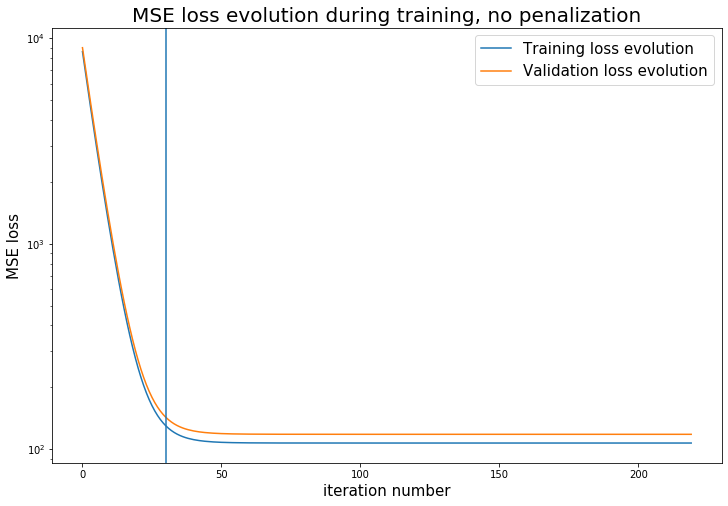

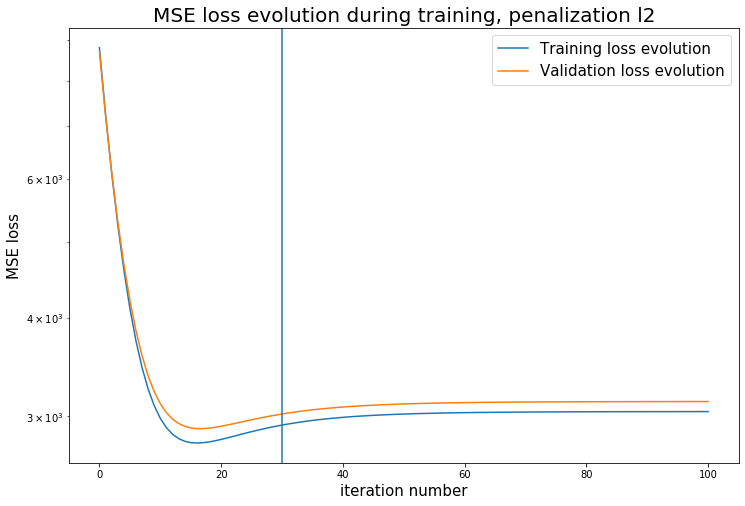

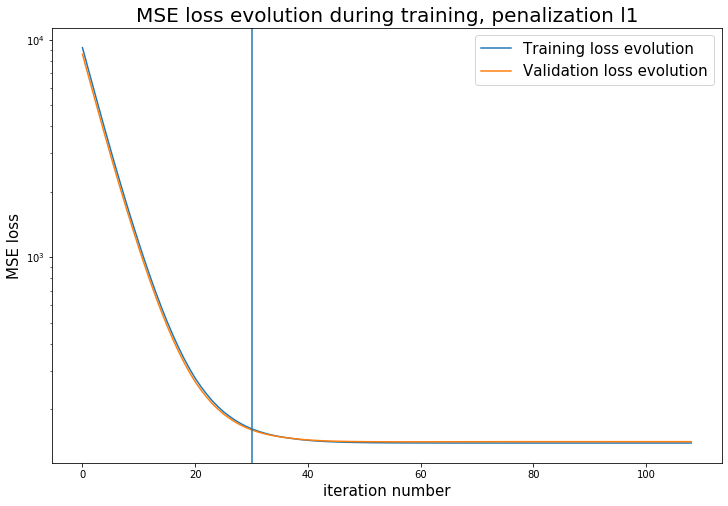

In [5]:
linear_regressor.plot_loss_history()
ridge_linear_regressor.plot_loss_history()
lasso_linear_regressor.plot_loss_history()

## Questions:
#### - What are l1 and l2 penalization strategies useful for? Did you achieve to improve your model's performance with them? Try different penalization values.

L1 and L2 are useful to avoid overfit, by penalizing the parameters which are not influencial in the model.  
Yes we achieve convergence quicker with l2 and l1 than without penalization.However the error is higher with L2 penalization.  
1e-5: Converge at 30 without penalization , 30 with L2 , 30 with L1  
5e-2: Converge at 40 without penalization (error 105), 18 with L2 (error 1930), 40 with L1 (error 120)  
1e-1: Converge at 40 without penalization (error 103), 30 with L2 (error 3123), 18 with L1 (error 140)  

#### - Consider the parameters plot. What could you conclude about the features information?


# II - Non linear unidimensional regression

## II a) - Loading the data

In [6]:
data = pd.read_csv('data/non_linear.csv', header=None)
X, Y = data.values[:, :-1], data.values[:, -1]
X, Y = X.reshape((Y.shape[0], 1)), Y.reshape((Y.shape[0], 1))

## II b) - Visualizing the data

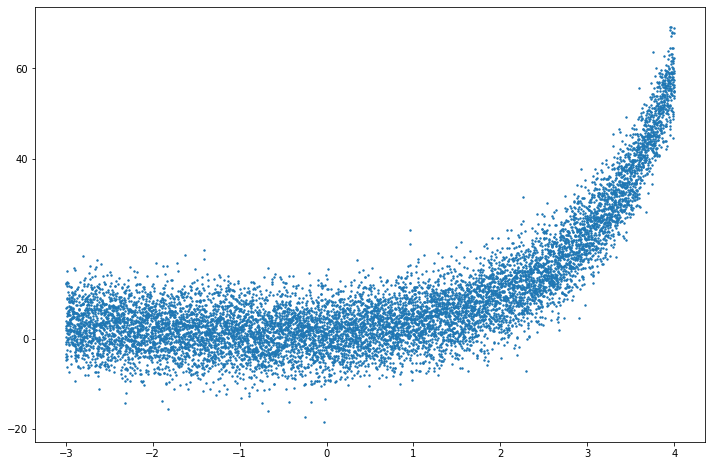

In [7]:
plt.figure(figsize=(12, 8))
plt.scatter(X, Y, s=2)
plt.show()

- Notice the relation between $X$ and $Y$ is non linear
- You are supposed to map X to a new non linear representation more suited to the type of dependance between $X$ and $y$
- Using this new representation of $X$ use the linear regressor properties from the beginning to perform predictions

In [8]:
class PolynomialRegressor(LinearRegressor):
    def __init__(self, X, Y, degree=2, penalization=None):
        self.degree = degree
        self.initial_X_tr, self.initial_X_val, _, _ = self.split_train_validation(X, Y)
        X_transformed = self.non_linear_mapping(X)
        super(PolynomialRegressor, self).__init__(X_transformed, Y, penalization)

    def split_train_validation(self, X, Y, test_size=0.25, seed=True):
        random_state = 42 if seed else np.random.randint(1e3)
        X_tr, X_val, Y_tr, Y_val = train_test_split(X, Y, test_size=test_size, random_state=random_state)
        return X_tr, X_val, Y_tr, Y_val

    # Must return a new features matrix based on a polynomial transformation
    def non_linear_mapping(self, X):
        # TODO:
        # Here do the mapping 
        new_X = np.ones(X.shape)
        for d in range(self.degree):
            new_row = np.power(X,d+1)
            new_X = np.concatenate((new_X,new_row),axis=1)
        return new_X
    
    def predict(self, X, apply_features_transformation=False):
        if apply_features_transformation:
            X_transformed = self.non_linear_mapping(X)
            return super(PolynomialRegressor, self).predict(X_transformed)
        else:
            return super(PolynomialRegressor, self).predict(X)
        
    def plot_prediction(self):
        assert self.initial_X_val.shape[1] == 1, "Too high dimensional design matrix to be plotted!"
        plt.figure(figsize=(12, 8))
        plt.scatter(self.initial_X_val, self.Y_val, s=5)
        plt.scatter(
            self.initial_X_val, self.predict(self.initial_X_val, apply_features_transformation=True), 
            color='red', s=5
        )
        plt.title("Prediction with polynomial regressor, degree={}".format(self.degree), fontsize=15)
        plt.show()

In [9]:
polynomial_regressor = PolynomialRegressor(X, Y, degree=3)
polynomial_regressor.fit(initial_step=1e-3, max_iterations=500, verbose=True)

iteration number: 1	 training loss: 97.7920	 validation loss: 98.1549
iteration number: 2	 training loss: 86.2504	 validation loss: 87.1332
iteration number: 3	 training loss: 80.4889	 validation loss: 81.7194
iteration number: 4	 training loss: 76.8829	 validation loss: 78.3301
iteration number: 5	 training loss: 74.1226	 validation loss: 75.6981
iteration number: 6	 training loss: 71.7304	 validation loss: 73.3775
iteration number: 7	 training loss: 69.5298	 validation loss: 71.2131
iteration number: 8	 training loss: 67.4535	 validation loss: 69.1512
iteration number: 9	 training loss: 65.4745	 validation loss: 67.1733
iteration number: 10	 training loss: 63.5806	 validation loss: 65.2722
iteration number: 11	 training loss: 61.7650	 validation loss: 63.4444
iteration number: 12	 training loss: 60.0232	 validation loss: 61.6873
iteration number: 13	 training loss: 58.3516	 validation loss: 59.9985
iteration number: 14	 training loss: 56.7470	 validation loss: 58.3756
iteration numbe

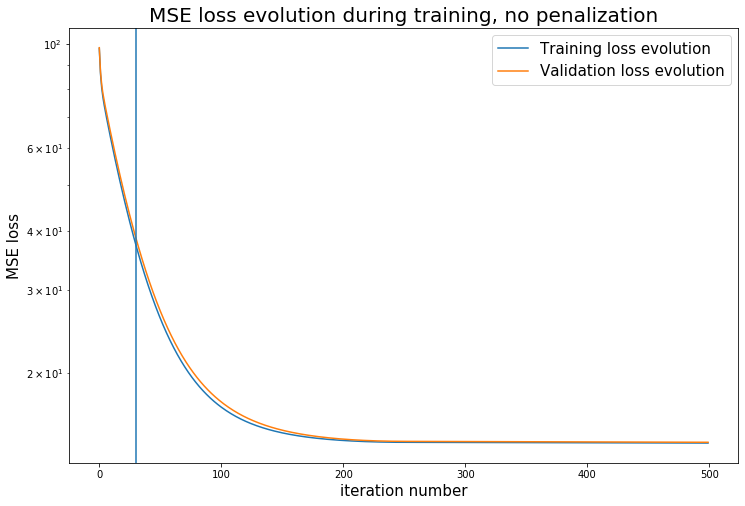

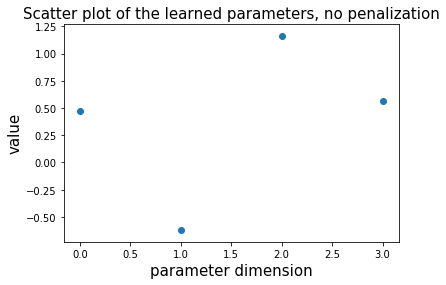

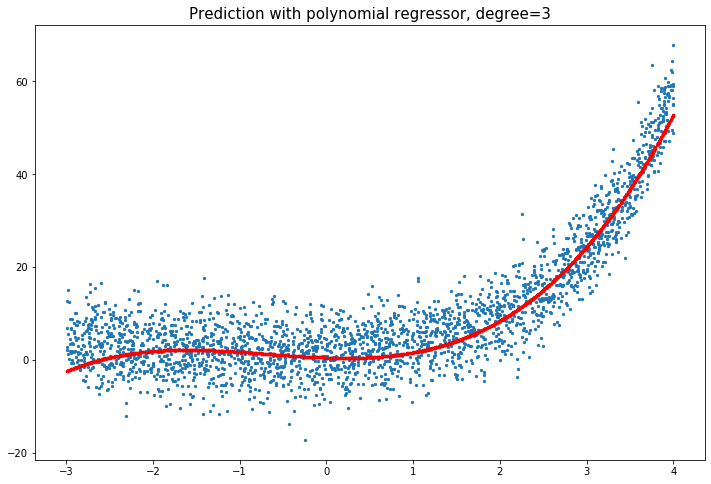

In [10]:
polynomial_regressor.plot_loss_history()
polynomial_regressor.plot_parameters()
polynomial_regressor.plot_prediction()

## Questions:
#### - Did you succeed to fit the data using a non linear mapping transformation?  
Yes
#### - Try different degrees, which one leads you to the best validation error?
- Learning rate = 1e-2 ,deg = 2 : 18.5
- Learning rate = 1e-3 ,deg = 2 : 26.3306
- Learning rate = 1e-2, deg = 3 : Inf
- Learning rate = 1e-3, deg = 3 : 13.9433 
- Learning rate = 1e-4, deg = 4 : 16  
We obtain the lowest validation error using a 3rd degree polynomial regressor, meaning that the data matches better with this expression.

# III - Logistic regression

## III a) - Loading the data

In [11]:
data = pd.read_csv('data/breast_cancer_classification.csv', header=None)
X, Y = data.values[:, :-1], data.values[:, -1]
Y = Y.reshape((Y.shape[0], 1))


## III b) - Problem definition

Using the sigmoid function $\sigma(x)$ defined as:

$\sigma(x) = \frac{1}{1 + \exp(-x)}$

We can define our binary cross-entropy cost function $J(\theta)$ as follows:
$$
J(\mathbf{X}, \mathbf{Y}; \theta) = -\frac{1}{n} \sum_{i=1}^n Y_i \log \sigma(\mathbf{X_i}\mathbf{\theta}) + (1 - Y_i) \log (1 - \sigma(\mathbf{X_i} \mathbf{\theta})),
$$
with $\mathbf{Y} = [y_1 \cdots y_n]$, $\mathbf{X} = [\mathbf{x_1} \cdots \mathbf{x_n}]$,

$\mathbf{Y} \in \mathbb{R}^{n\times{1}}$ being the vector of labels, $\mathbf{X} \in \mathbb{R}^{n\times{p}}$ being the vector of features, $\mathbf{\theta} \in \mathbb{R}^{p\times{1}}$ being our parameters, and $n$ the number of samples.

Now we can calculate the gradient $\nabla J(\mathbf{\theta})$:
$$
\nabla_{\theta} J(\mathbf{X}, \mathbf{Y})^T = - \frac{1}{n} \sum_{i=1}^n \mathbf{X_i}(Y_i - \sigma(\mathbf{X_i}\mathbf{\theta}))
$$
$$
\nabla_{\theta} J(\mathbf{X}, \mathbf{Y}) = - \frac{1}{n} \mathbf{X}^T(\mathbf{Y} - \sigma(\mathbf{X}\theta))
$$

It leads us to the gradient descend (GD) iterative algorithm:
$$
\mathbf{\theta}_{t+1} := \mathbf{\theta}_{t} - \eta_t \nabla_{\theta} J(\mathbf{X}, \mathbf{Y})
$$

And finally, our linear prediction $\mathbf{\hat{Y}}$ can be expressed as:
$$
\mathbf{\hat{Y}} = \sigma(\mathbf{X}\mathbf{\theta})
$$
- **no $\mathbf{\hat{Y}}_i$ should reach $0$ or $1$. If it does get rounded to $0$ or $1$, prevent that from happening by adding or removing EPSILON to $\mathbf{\hat{Y}}_i$**

In [15]:
# Logistic Regression being a GLM, we can make an inheritance from the LinearRegressor class
class LogisticRegressor(LinearRegressor):
    def __init__(self, X, Y, penalization=None):
        super(LogisticRegressor, self).__init__(X, Y, penalization)
        self.X_tr, self.X_val = self.normalize(self.X_tr), self.normalize(self.X_val)
    
    # Return a normalized matrix with standardized features 0 mean 1 std
    def normalize(self, X):
        # TODO:
        return (X - X.mean())/X.std()
    
    # Return the model's accuracy on the validation dataset
    def accuracy_on_validation(self):
        # TODO:
        total = self.X_val.shape[0]
        pred = np.round(self.predict(self.X_val))
        accuracy = np.sum(pred == self.Y_val)/total
        return accuracy
        
    # Sigmoid function
    def sigmoid(self, X):
        # TODO:
        return 1/(1+np.exp(-X))

    def predict(self, X, apply_normalization=False):
        if apply_normalization:
            X = self.normalize(X)
        return self.sigmoid(X.dot(self.theta))

    def compute_grad(self, X, Y, loss='CE'):
        """Binary cross-entropy gradient"""
        assert(X.shape[0] == Y.shape[0])
        n = X.shape[0]
        if loss == 'CE':
            # TODO:
            error = Y - self.predict(X)
            grad = (-1/n)*np.dot(X.T,error)
            if self.penalization == 'l2':
                # TODO:
                 grad += self.gamma*np.sum(2*self.theta)
            if self.penalization == 'l1':
                # TODO:
                 grad += self.gamma*np.sum(np.sign(self.theta))
        else:
            raise NotImplementedError
        return grad

    def step_gradient_descent(self, step, X, Y):
        self.grad_theta = self.compute_grad(X, Y, loss='CE')
        # TODO:
        self.theta = self.theta - step*self.grad_theta
    
    # Must return the given loss, penalized or not, for Y_true and Y_pred as inputs
    def loss(self, Y_true, Y_pred, loss='CE'):
        """Binary cross-entropy loss"""
        assert(Y_true.shape[0] == Y_pred.shape[0])
        n = Y_true.shape[0]
        if loss == 'CE':
            div = -(1/n)
            a = Y_true * np.log(Y_pred)
            b = (1 - Y_true) * np.log(1 - Y_pred)
            # TODO:
            loss = div * np.sum(a+b)
            if self.penalization == 'l2':
                # TODO:
                loss += self.gamma * np.sum(np.square(self.thetas))
            elif self.penalization == 'l1':
                # TODO:
                loss += self.gamma * np.sum(np.absolute(self.thetas))
        else:
            raise NotImplementedError
        return loss

iteration number: 1	 training loss: 0.6038	 validation loss: 0.6033
iteration number: 2	 training loss: 0.5197	 validation loss: 0.5108
iteration number: 3	 training loss: 0.5057	 validation loss: 0.4942
iteration number: 4	 training loss: 0.5006	 validation loss: 0.4879
iteration number: 5	 training loss: 0.4969	 validation loss: 0.4836
iteration number: 6	 training loss: 0.4937	 validation loss: 0.4800
iteration number: 7	 training loss: 0.4905	 validation loss: 0.4765
iteration number: 8	 training loss: 0.4875	 validation loss: 0.4732
iteration number: 9	 training loss: 0.4845	 validation loss: 0.4700
iteration number: 10	 training loss: 0.4816	 validation loss: 0.4669
iteration number: 11	 training loss: 0.4788	 validation loss: 0.4639
iteration number: 12	 training loss: 0.4760	 validation loss: 0.4609
iteration number: 13	 training loss: 0.4733	 validation loss: 0.4580
iteration number: 14	 training loss: 0.4706	 validation loss: 0.4551
iteration number: 15	 training loss: 0.4680

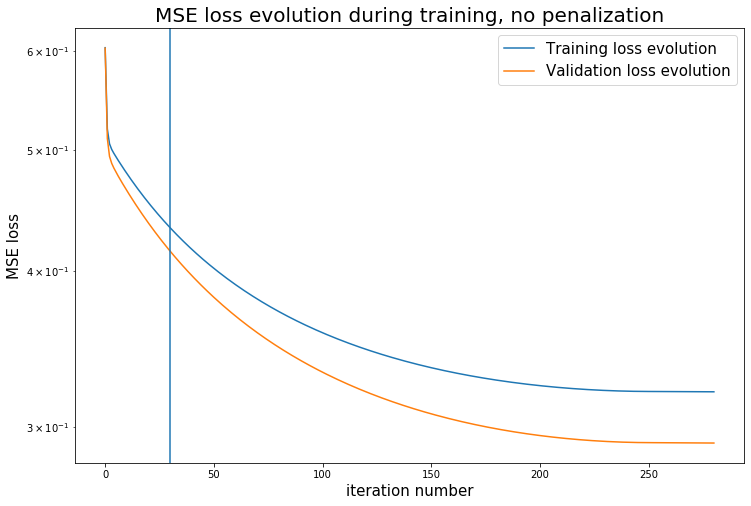

In [16]:
logistic_regressor = LogisticRegressor(X, Y)
logistic_regressor.fit(max_iterations=1000, initial_step=1e-1, step_decay=True)
logistic_regressor.plot_loss_history()

In [17]:
#print(logistic_regressor.accuracy_on_validation())
logistic_regressor.accuracy_on_validation()

0.951048951048951

## Questions:
#### - Describe your normalization strategy and why it is important
- For normalization, we want to have a mean of 0 and a standard deviation of 1. To achieve this result, we substrate the mean from X and divide by X's std. This step is important because we want to feed values between 0 and 1 in the sigmoid function (acording to its definition), making the train step easier and thus having better performance.   
#### - Why do we need a different loss function for a classification problem (why not MSE again?)
- MSE is not a good loss function for classification (and logistic regression in particular) because it does not penalize misclassification. In certain cases, MSE leads to class imbalance. Binary cross entropy strongly penalize misclassifcations, as the cost function tends to infinity when the opposite value is picked.  
#### - Why is the normalization particulary relevant in this case? Compare the performances with and without it. Comment.
- With normalization : 90,90% accuracy
- Without normalization : 49,64% accuracy + we get nan values during training  
Using normalization greatly reduces variance because it reduces the interval on which the values are defined. 